In [1]:
import pygame, sys, random
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import math
import matplotlib.pyplot as plt
import pylab

num_episodes = 10

agentRadius = 10

# get size of state and action from environment

boundaryPos = [400, 590]
boundaryLength = [70, 70]
initPosAgent = [boundaryPos[0] + boundaryLength[0] / 2, boundaryPos[1] + boundaryLength[1] / 2]#[boundaryPos[0], boundaryPos[1] + boundaryLength[1]]
goalPos = [boundaryPos[0] + boundaryLength[0], boundaryPos[1]]

moveObstacles = True
action_size = 9
obsNumber = 2
# state_size = obsNumber * 2 + 1
state_size = 3
# state_size = obsNumber + 1

Using TensorFlow backend.


In [2]:
# A2C(Advantage Actor-Critic) agent
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.load_model = True
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.actor_lr = 0.00002
        self.critic_lr = 0.00005

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        if self.load_model:
            self.actor.load_weights("./Practice004_DataSave/Actor.h5")
            self.critic.load_weights("./Practice004_DataSave/Critic.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_normal'))
        actor.add(Dense(self.action_size, activation='softmax', kernel_initializer='glorot_normal'))
        actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_normal'))
        critic.add(Dense(self.value_size, activation='linear', kernel_initializer='glorot_normal'))
        critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        # Policy = 확률. 이 확률에 맞게 Action을 선택
        print policy
        return np.random.choice(self.action_size, 1, p=policy)[0]
#         return policy

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

In [3]:
def ckWall(xPos, yPos):
    flagWall = 0
    if(xPos < boundaryPos[0]):
        xPos = boundaryPos[0]
        flagWall = -1
    elif(xPos > boundaryPos[0] + boundaryLength[0]):
        xPos = boundaryPos[0] + boundaryLength[0]
        flagWall = -1
    if(yPos < boundaryPos[1]):
        yPos = boundaryPos[1]
        flagWall = -1
    elif(yPos > boundaryPos[1] + boundaryLength[1]):
        yPos = boundaryPos[1] + boundaryLength[1]
        flagWall = -1
        
    return [xPos, yPos, flagWall]

In [4]:
def ckInit(initLoc, obsLoc):
    if math.sqrt((initLoc[0] - obsLoc[0])**2 + (initLoc[1] - obsLoc[1])**2) <= 2*agentRadius + 1:
        if initLoc[0] - obsLoc[0] < 0:
            obsLoc[0] += 1
        else:
            obsLoc[0] -= 1
        if initLoc[1] - obsLoc[1] < 0:
            obsLoc[1] += 1
        else:
            obsLoc[1] -= 1
    if math.sqrt((goalPos[0] - obsLoc[0])**2 + (goalPos[1] - obsLoc[1])**2) <= 2*agentRadius + 1:
        obsLoc[0] -= 1
        obsLoc[1] += 1
    return obsLoc

In [5]:
def stateGenerator(obsPosition, agtPosition, idx):
    returnSum = []
    returnSum = returnSum + [agtPosition[0] - obsPosition[idx][0], agtPosition[1] - obsPosition[idx][1]]
    returnSum = returnSum + [math.sqrt((agtPosition[0] - goalPos[0])**2 + (agtPosition[1] - goalPos[1])**2)]
    returnSum = np.reshape(returnSum, [1, 3])
    return returnSum

In [6]:
def ckCollision(obsPosition, agtPosition):
    for i in range(0,obsNumber):
        if math.sqrt((agtPosition[0] - obsPosition[i][0])**2 + (agtPosition[1] - obsPosition[i][1])**2) <= 20:
            return True
        else:
            return False

In [7]:
def takeAction(action):
    xAction = 0
    yAction = 0
    if action == 0:
        xAction = 1
    elif action == 1:
        xAction = 1
        yAction = 1
    elif action == 2:
        xAction = 1
        yAction = -1            
    elif action == 3:
        xAction = -1
        yAction = 1
    elif action == 4:
        xAction = -1
    elif action == 5:
        xAction = -1
        yAction = -1
    elif action == 6:
        yAction = -1
    elif action == 7:
        yAction = 1
    elif action  == 8:
        xAction = 0
        yAction = 0
        
    return [xAction, yAction]

In [19]:
pygame.init()
screen = pygame.display.set_mode([1280,960])
screen.fill([200, 200, 200])

# make A2C agent
agent = A2CAgent(state_size, action_size)

rList, episodes = [], []

# Make Obstacles (obsNumber)
obstaclePos = [[0, 0] for _ in range(obsNumber)]
for i in range(0,obsNumber):
    while True:
        obstaclePos[i][0] = boundaryPos[0] + random.randrange(1, boundaryLength[0])
        obstaclePos[i][1] = boundaryPos[1] + random.randrange(1, boundaryLength[1])
        if obstaclePos[i][0] <= goalPos[0] - agentRadius or obstaclePos[i][0] >= goalPos[0] + agentRadius:
            if obstaclePos[i][1] >= goalPos[1] + agentRadius or obstaclePos[i][1] <= goalPos[1] - agentRadius:
                if obstaclePos[i][0] <= initPosAgent[0] - agentRadius or obstaclePos[i][0] >= initPosAgent[0] + agentRadius:
                    if obstaclePos[i][1] >= initPosAgent[1] + agentRadius or obstaclePos[i][1] <= initPosAgent[1] - agentRadius:
                        break

for e in range(num_episodes):
    # Initialize
    done = False
    score = 0
    x = initPosAgent[0]#boundaryPos[0]
    y = initPosAgent[1]#boundaryPos[1]
    print("Episode ", e, "Starts!")
    #state = np.reshape(state, [1, state_size])
    tmpX = 0
    tmpY = 0
    while not done:
        getPolicy = []
#         tmpPolicyA = []
#         tmpPolicyB = []
        
        for i in range(0, obsNumber):
            state = stateGenerator(obstaclePos, [x,y], i)
#             [action, badAction] = agent.get_action(state)
#             tmpPolicyA = np.log(agent.get_action(state))
            action = agent.get_action(state)
#             if(i > 0):
#                 getPolicy = np.add(tmpPolicyA, getPolicy)
#                 getPolicy = np.multiply(tmpPolicyA, getPolicy)
#             else:
#                 getPolicy = tmpPolicyA
#             print("Local",i,":", tmpPolicyA)
#         getPolicy = np.exp(getPolicy)
#         getPolicy = getPolicy / sum(getPolicy)
#             action = np.random.choice(action_size, 1, p = getPolicy)[0]
#         print("Total:", getPolicy)
            
            xMove = 0
            yMove = 0

            [xMove, yMove] = takeAction(action)
            
#             tmpX = tmpX + xMove
#             tmpY = tmpY + yMove
            x = x + xMove
            y = y + yMove
            
            if ckCollision(obstaclePos, [x,y]) == True:
                print("Collision Predicted!")
                x = x - xMove
                y = y - yMove
            
            wallFlag = 0
            collisionFlag = 0
#         if tmpX != 0 or tmpY != 0:
#             x = int(round(x + tmpX / math.sqrt(tmpX**2 + tmpY**2)))
#             y = int(round(y + tmpY / math.sqrt(tmpX**2 + tmpY**2)))
        print "====================================================="
        [x, y, wallFlag] = ckWall(x,y)
        pygame.draw.circle(screen, [100, 100, 255], [x,y], 10, 0)
#         next_state = stateGenerator(obstaclePos, [x,y])

        if(math.sqrt((x - goalPos[0])**2 + (y - goalPos[1])**2) <= 20):
            print("Goal Reached!")           
            collisionFlag = 1
            done = 1
                
        for i in range(0,obsNumber):
            if moveObstacles:
                obstaclePos[i][0] = obstaclePos[i][0] + random.randrange(-1,2)
                obstaclePos[i][1] = obstaclePos[i][1] + random.randrange(-1,2)
                [obstaclePos[i][0], obstaclePos[i][1], _] = ckWall(obstaclePos[i][0], obstaclePos[i][1])
                obstaclePos[i] = ckInit(initPosAgent ,obstaclePos[i])

            pygame.draw.circle(screen, [255, 50 + 20*i, 50 + 20 * i], obstaclePos[i], 10, 0)
            if math.sqrt((x - obstaclePos[i][0])**2 + (y - obstaclePos[i][1])**2) <= 20:
                print("Collision!")
                collisionFlag = -1
                ObjectIndex = i
                done = True 
#         if wallFlag == -1:
#             done = True
            
        if not done:
            reward = -0.1
            if wallFlag == -1:
                reward = -1
        else:
            if collisionFlag == 1:
                reward = 10000
                rList.append(1)
            elif collisionFlag == -1:
                reward = -10000
                rList.append(0)
#             next_state, reward, done, ininitPosAgentfo = env.step(action)
#             next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100
#             reward = reward if not done or score == 499 else -100
        
#         agent.train_model(state, action, reward, next_state, done)

        score += reward
#         state = next_state

        if done:
            # every episode, plot the play time

            episodes.append(e)
            pylab.plot(episodes, rList, 'b')
#             pylab.savefig("./Practice004_DataSave/ActorCriticGraph_Test.png")
        #circle(Surface, color, pos, radius, width=0)
        pygame.draw.circle(screen, [100,255,100], [goalPos[0],goalPos[1]], 10, 2)
        #rect(Surface, color, Rect, width=0)
        pygame.draw.rect(screen, [255,100,100],[boundaryPos[0] - agentRadius, boundaryPos[1] - agentRadius, boundaryLength[0] + agentRadius * 2, boundaryLength[1] + agentRadius * 2],2)
        pygame.display.flip()
        screen.fill([200,200,200])
    print score
    # save the model
#     if e % 50 == 0:
#         agent.actor.save_weights("./Practice004_DataSave/Actor.h5")
#         agent.critic.save_weights("./Practice004_DataSave/Critic.h5")



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 128)               512       
_________________________________________________________________
dense_46 (Dense)             (None, 9)                 1161      
Total params: 1,673
Trainable params: 1,673
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 128)               512       
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 129       
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
('Episode ', 0, 'Starts!')
[  4.44748839e-05   6.42165716e-04   4.75838334e-

[  3.08562835e-06   4.59046801e-09   9.98806477e-01   1.74195566e-06
   2.16989179e-07   1.21311487e-15   1.18663057e-03   5.05287048e-08
   1.82132476e-06]
[  2.91226152e-02   9.48397792e-05   8.93242508e-02   7.80887855e-03
   7.68054323e-03   8.11667442e-01   4.83931378e-02   8.95896519e-04
   5.01233526e-03]
[  2.40947793e-06   5.93796790e-09   9.99294043e-01   2.00650857e-06
   1.29712546e-07   7.30134393e-17   7.00634962e-04   3.92055419e-08
   6.78008632e-07]
[  5.22277579e-02   1.66762999e-04   3.38919193e-01   1.12547874e-02
   1.21656125e-02   4.39035982e-01   1.34180650e-01   1.57791178e-03
   1.04714232e-02]
[  2.64374239e-06   2.25946515e-08   9.99489069e-01   3.44241289e-06
   1.25957484e-07   4.85371948e-17   5.04223455e-04   4.16455244e-08
   4.29175572e-07]
[  3.54774445e-02   1.22327270e-04   6.83384418e-01   6.94510993e-03
   7.79431127e-03   1.11835547e-01   1.45181581e-01   9.78434808e-04
   8.28081276e-03]
[  4.26961014e-06   1.41940546e-07   9.99598563e-01   8.72

[  1.41061505e-03   1.37580437e-05   1.31312663e-06   9.48314730e-04
   1.42376276e-03   9.95697618e-01   1.05805419e-04   1.94980443e-04
   2.03945281e-04]
[  3.17223457e-04   2.34279710e-07   9.60873127e-01   3.30072762e-05
   8.62861270e-06   9.36413863e-11   3.85902077e-02   4.15207387e-06
   1.73416134e-04]
[  5.51515725e-03   5.28419878e-05   3.40507795e-05   3.27740912e-03
   4.06414038e-03   9.83836830e-01   1.32023869e-03   7.40699877e-04
   1.15865329e-03]
[  9.35396893e-05   7.91691477e-08   9.83690798e-01   1.34452712e-05
   3.03439037e-06   4.32521293e-12   1.61438622e-02   1.07218295e-06
   5.41283553e-05]
[  2.00424548e-02   1.99760267e-04   7.95729400e-04   1.07794767e-02
   1.10404938e-02   9.32822824e-01   1.55472755e-02   2.70955567e-03
   6.06244383e-03]
[  3.14381359e-05   3.11738049e-08   9.92827475e-01   7.15205897e-06
   1.34047343e-06   2.52626912e-13   7.11237453e-03   4.31498393e-07
   1.97782265e-05]
[  5.00142537e-02   5.31071797e-04   5.34908706e-03   2.14

[  1.96856428e-02   1.67484483e-04   7.55178273e-01   3.91783891e-03
   3.20155290e-03   2.13074949e-04   2.05479980e-01   1.32341182e-03
   1.08326972e-02]
[  2.20713682e-05   4.66851779e-05   9.99565423e-01   1.81697629e-04
   5.10320092e-07   1.40750468e-18   1.83050070e-04   5.31443050e-07
   7.08900885e-08]
[  6.75046304e-03   5.79590705e-05   8.76212358e-01   1.34877744e-03
   9.56367992e-04   2.07544253e-05   1.10244654e-01   3.48717498e-04
   4.06002207e-03]
[  6.60990554e-05   8.76629783e-04   9.97929931e-01   9.07304464e-04
   1.69756970e-06   1.23838440e-18   2.15786684e-04   2.42550482e-06
   7.61848540e-08]
[  3.95346479e-03   4.42459277e-05   9.08437490e-01   9.76675190e-04
   6.22216088e-04   5.59681348e-06   8.27194899e-02   2.24110438e-04
   3.01664555e-03]
[  1.45558559e-04   1.23702884e-02   9.84254479e-01   3.04333447e-03
   2.44078979e-06   3.34640234e-19   1.79559909e-04   4.40166195e-06
   4.06035312e-08]
[  1.81240612e-03   2.63809907e-05   9.44482148e-01   6.27

[ 0.10890393  0.0011411   0.22390005  0.02386177  0.03541316  0.06587441
  0.46753153  0.01185794  0.06151611]
[  8.55579856e-06   3.87447479e-08   9.98549759e-01   7.52034111e-06
   5.98752990e-07   2.47231108e-15   1.43067632e-03   2.04656359e-07
   2.65523954e-06]
[  4.75069024e-02   3.63606319e-04   4.53450918e-01   9.04888380e-03
   9.52956639e-03   1.12008885e-03   4.43988830e-01   4.08537872e-03
   3.09057869e-02]
[  5.71688815e-06   7.05838374e-08   9.99172986e-01   7.60421653e-06
   3.38963730e-07   7.34692344e-16   8.11958162e-04   1.09937993e-07
   1.13462045e-06]
[  4.13397774e-02   3.26667621e-04   5.42140424e-01   7.91998859e-03
   8.07940122e-03   1.13865198e-03   3.70871603e-01   3.30860284e-03
   2.48749182e-02]
[  6.77923845e-06   5.95880692e-07   9.99568880e-01   1.81804244e-05
   2.79650351e-07   9.97245042e-17   4.04828839e-04   1.24610210e-07
   3.72051431e-07]
[  1.51015613e-02   1.12775342e-04   7.67878294e-01   2.85295513e-03
   2.16149027e-03   6.55188196e-05 

Percent of successful episodes: 60.0%


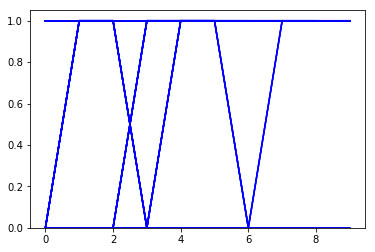

In [20]:
print("Percent of successful episodes: " + str(100.0 * sum(rList)/num_episodes) + "%")

plt.bar(range(len(rList)), rList, color = "Blue", width = 0.00001)
plt.show()